**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [19]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


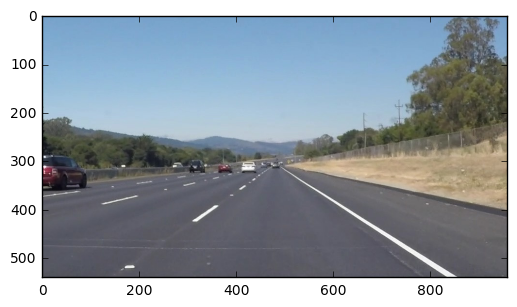

In [20]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [21]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [22]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg']

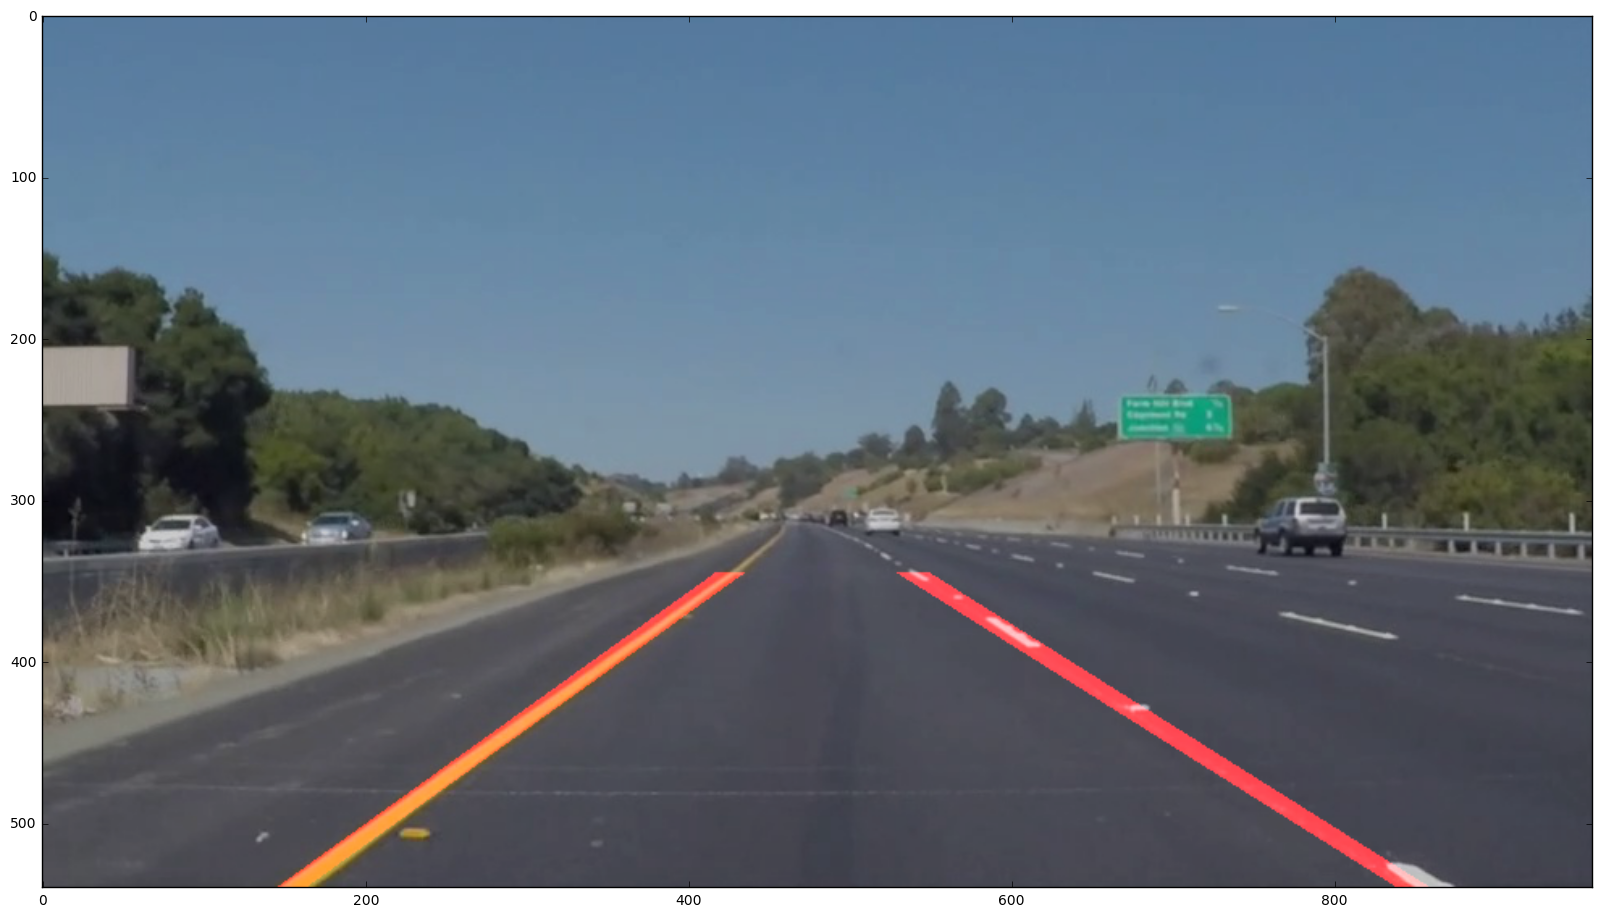

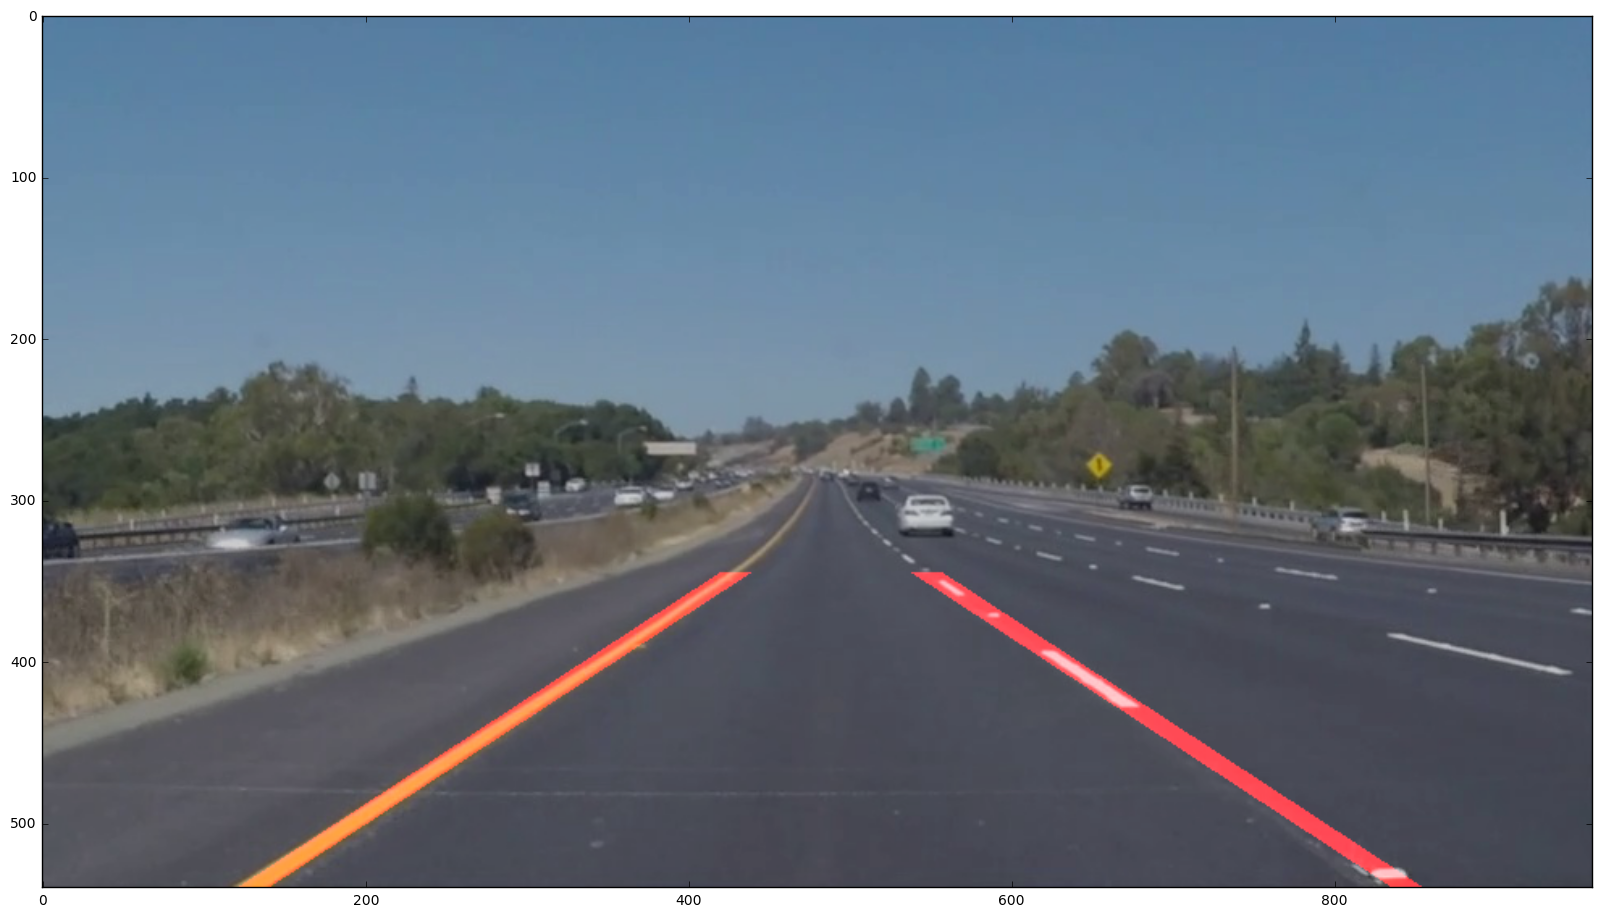

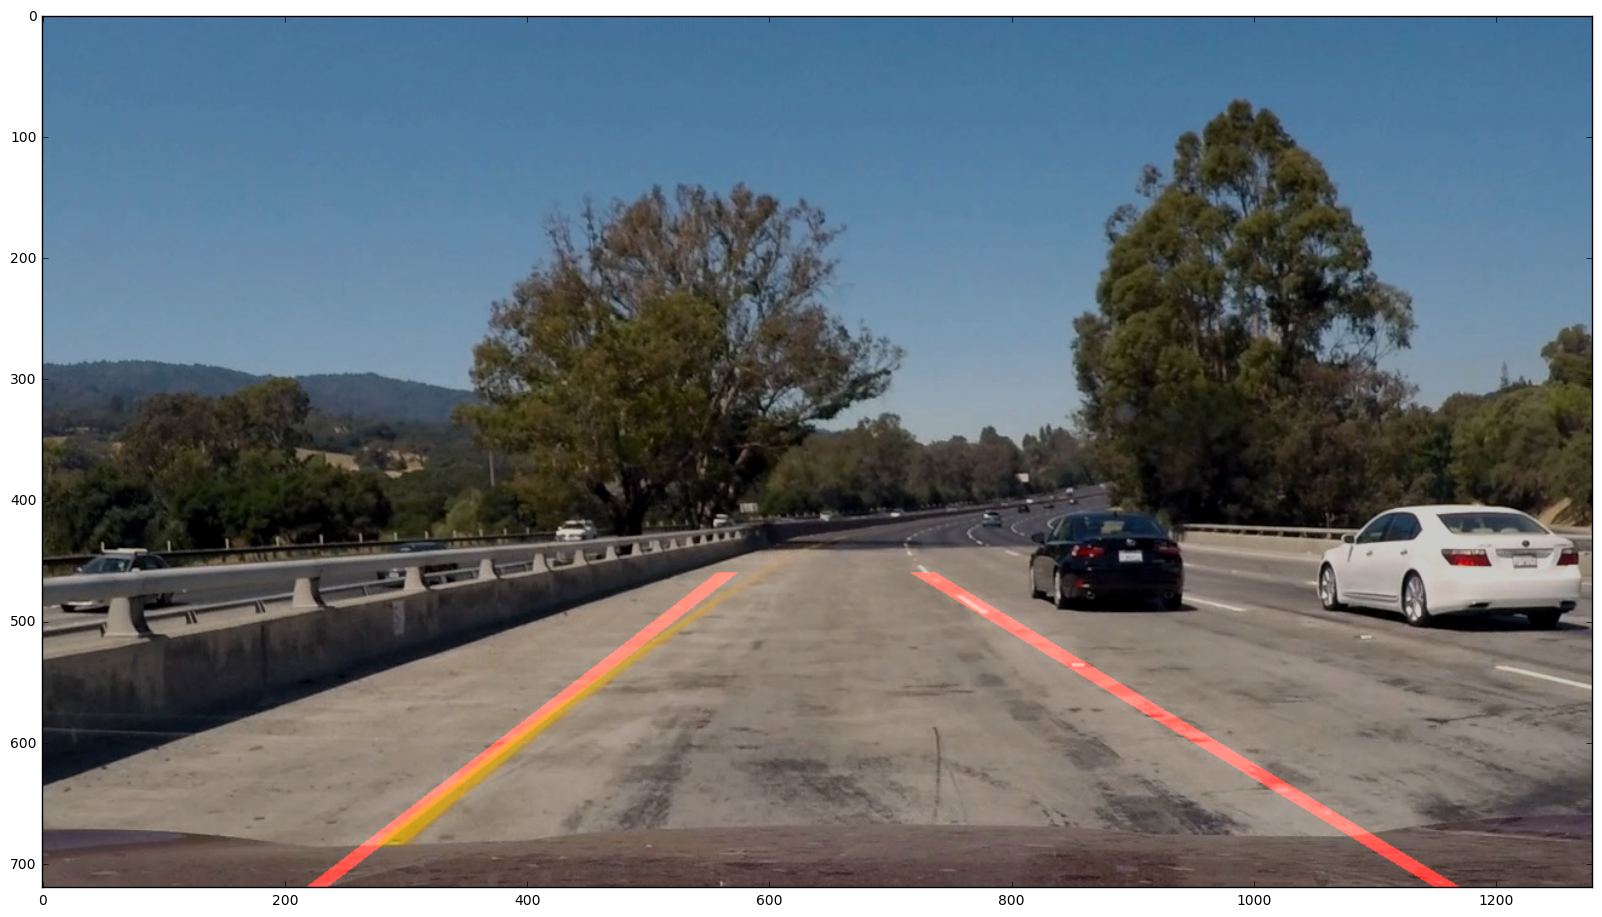

In [32]:
# All tweakable parameters
grayscale_argument = [0.8, 0.1, 0.1] # This value highlights yellow lanes very well
horizon_relative_height = 0.55 # Relative height of the horizon from top of the image
trapeze_top = 0.61 # Height of the top part of region of interest
trapeze_display_top = 0.64 # Save as above, but it only trims lines and not image
lane_angle_limit = 0.5 # Approx 28 degree.
gaussian_blur_kernel = 3
canny_low_threshold = 100
canny_high_threshold = 200
rho = 1
theta = np.pi / 180
threshold = 50
min_line_length = 25
max_line_gap = 3


def better_grayscale(img):
    # In challenge video there is a piece where yellow line dissappears from screen
    # after converting image to grayscale.
    # Actually, grayscale conversion can be parametrized.
    # I've opened Photoshop and played with different parameters of conversion
    # grayscale_argument - it a result of my experiments
    
    args = np.array(grayscale_argument)
    return np.dot(img, args).astype(np.uint8)


def curtain(img, curtain_height):
    # Helper function which discards upper part of the 'img', ending at 'curtain_height'
    img_width = img.shape[1]
    img_height = img.shape[0]

    vertices = np.array([[(0, img_height),
                          (img_width, img_height),
                          (img_width, img_height * curtain_height),
                          (0, img_height * curtain_height)]], dtype=np.int32)

    return region_of_interest(img, vertices)


def trim_to_trapeze(img):
    height = img.shape[0]
    width = img.shape[1]
    horizon = height * horizon_relative_height
    vertices = np.array([[(width / 2, horizon), (0, height), (width, height)]], dtype=np.int32)
    return curtain(region_of_interest(img, vertices), trapeze_top)


def prolong_line(line, img_height, img_weight):
    # Just some linear algebra to compute arguments of the line
    # and then use them to stretch line on the full screen
    x1 = line[0][0]
    y1 = line[0][1]
    x2 = line[0][2]
    y2 = line[0][3]

    if x1 == x2:
        return np.array([[x1, 0, x1, img_height]], np.int32)

    k = (y1 - y2) / (x1 - x2)
    b = (y1 + y2 - k * (x1 + x2)) / 2

    fx1 = 0
    fy1 = b
    fx2 = img_weight
    fy2 = k * fx2 + b

    result = np.array([[fx1, fy1, fx2, fy2]], np.int32)
    return result


def get_line_angle(line):
    x1 = line[0][0]
    y1 = line[0][1]
    x2 = line[0][2]
    y2 = line[0][3]

    angle = np.pi / 2
    if x1 != x2:
        angle = math.atan((y1 - y2) / (x1 - x2))

    return angle


def is_lane_line(line):
    # Acutally, there are a lot of lines on the sample videos.
    # For example - car's hood in the challenge video
    # But lane lines should be close to vertical
    # so filter them
    return abs(get_line_angle(line)) > lane_angle_limit


def compute_average_line(lines):
    if len(lines) == 0:
        return None

    max_x = 0

    k_sum = 0
    b_sum = 0

    for line in lines:
        x1 = line[0][0]
        y1 = line[0][1]
        x2 = line[0][2]
        y2 = line[0][3]

        max_x = max(max_x, x1, x2)

        k = (y1 - y2) / (x1 - x2)
        b = (y1 + y2 - k * (x1 + x2)) / 2

        k_sum += k
        b_sum += b

    final_k = k_sum / len(lines)
    final_b = b_sum / len(lines)

    fx1 = 0
    fy1 = final_k * fx1 + final_b
    fx2 = max_x
    fy2 = final_k * fx2 + final_b

    return np.array([[fx1, fy1, fx2, fy2]], np.int32)


def get_left_right_lanes(lines):
    # left and right lanes can be distinguished by their slope
    left_lines = []
    right_lines = []

    for line in lines:
        angle = get_line_angle(line)
        if angle < 0:
            left_lines.append(line)
        if angle > 0:
            right_lines.append(line)

    left = compute_average_line(left_lines)
    right = compute_average_line(right_lines)

    return left, right


def detect_lanes(img):
    img_width = img.shape[1]
    img_height = img.shape[0]

    result = better_grayscale(img)
    result = gaussian_blur(result, gaussian_blur_kernel)
    result = canny(result, canny_low_threshold, canny_high_threshold)
    result = trim_to_trapeze(result)

    lines = cv2.HoughLinesP(result, rho, theta, threshold, np.array([]), minLineLength=min_line_length,
                            maxLineGap=max_line_gap)
    lines = filter(is_lane_line, lines)
    lines = map(lambda line: prolong_line(line, img_height, img_width), lines)
    return get_left_right_lanes(lines)


def draw_lanes_on_image(lanes, image):
    lanes = filter(lambda lane: lane is not None, lanes)
    line_img = np.zeros(image.shape, dtype=np.uint8)

    draw_lines(line_img, lanes, thickness=10)

    line_img = curtain(line_img, trapeze_display_top)
    return weighted_img(line_img, image)


def test_images():
    for img_name in os.listdir("my_test_images"):
        img = mpimg.imread('my_test_images/' + img_name)
        left, right = detect_lanes(img)

        lanes = [left, right]

        result = draw_lanes_on_image(lanes, img)

        plt.figure(figsize=(20, 20))
        plt.imshow(result, cmap='gray')


test_images()

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
left_lane = None
right_lane = None

bad_frames_limit = 3 # Vehicle moving at 100km/h will move ~3 meters in 3 frames
bad_frames = 0

def process_image(image):
    left, right = detect_lanes(image)
    global left_lane, right_lane, frame_limit, bad_frames
    
    if left == None or right == None:
        bad_frames += 1
        if bad_frames >= bad_frames_limit: 
            left_lane = None
            right_lane = None
            bad_frames = 0
    else: bad_frames = 0
    
    if left != None: left_lane = left
    if right != None: right_lane = right

    return draw_lanes_on_image([left_lane, right_lane], image)    

Let's try the one with the solid white lane on the right first ...

In [26]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 37.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 5.66 s, sys: 124 ms, total: 5.79 s
Wall time: 6.17 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [28]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:18<00:00, 39.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 18 s, sys: 464 ms, total: 18.4 s
Wall time: 18.8 s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Looks like I can continue solving this problem forever...

### Pipeline

My pipeline looks like the following

1) Convert image to grayscale. But I use my own conversion function.
This is due to the complications in the challenge video - if you convert it to grayscale
with provided function - even a human can barely distinguish left yellow line.

Yellow is basically a combination of red and green. What my code does - it "aligns" red, green and blue levels in yellow, so after conversion it looks like white. Changes to other parts of the image are minimal

2) Next I detect lines as in previous lessons

3) After lines are found I filter them: only lines that are not far from vertical are good

4) I extend lines to the entire screen

5) Than I divide them to left and right groups by their slope.

6) And finally, I average lines in each group 


### Now about where it is going to fail:
All parameters were picked by hand for conditions provided in videos. If anything changed - you might need to tweak them again. For example - night, rain, clouds.
<figure>
 <img src="http://freeuse.io/img_highres/1363-bend-curve-rainy-road.jpg" width="380" alt="Combined Image" />
</figure>

Provided algorithm also makes a lot of assumptions that may fail:

For example I assume that car never changes lane. But if it does - left and right lane detection might fail. For short moment one of the lanes will become vertical - that is bad too. But the worst thing is that region of interest is fixed. And too much noise will get in the field of view. 

Traffic in front of the car will definetely ruin algorithm too.

It will fail if there are no lane lines or they are drawn wrong.
<figure>
 <img src="http://parnasse.ru/images/photos/medium/article117265.jpg" width="380" alt="Combined Image" />
</figure>

And, most likely, when we move to other countries it might turn out that lanes are somewhat different there.


### Possible improvements

1) First I would prepare some videos where lanes are correctly marked by hand, thus converting this problem to supervised learning problem. It will be much easier to pick parameters when you have a fit function and you don't need to look through all images that you generated

2) To better distinguish lane lines from other lines in the image one can try to plot a hist graph,
where buckets are slopes of all lines in the image. And values are total lengths of the lines in a bucket. Nearest lane lines should form two biggest peaks on that graph

3) It is well known, that detecting an object is harder than tracking it. We can try to first detect lanes and than only track if they are still here. (And adjust them if they have moved, of course). Thus we can decrease computational load of our algorithm. 

4) We can use color information. Lanes are white and yellow. Roads are gray. If we see a line on a blue car - we can throw it out.

5) Center of the image has lower level of detail due to perspective. It might be useful to split region of interest to 2 or more parts: nearest part, farthest part etc. Each part might have an individual set of parameters. For example, we need more blur for nearest part than for nearest. 


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [30]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:13<00:00, 19.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 12.6 s, sys: 328 ms, total: 12.9 s
Wall time: 13.7 s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))